In [15]:
import pandas as pd
import numpy as np
import os
from pytz import timezone
from sympy import false

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


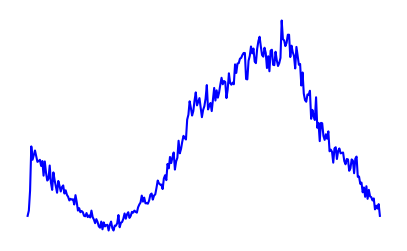

In [95]:
import matplotlib.pyplot as plt
import random
random_column = random.choice(sd_his.columns)
data_to_plot = sd_his[random_column].iloc[:288]
plt.figure(figsize=(5, 3))
plt.plot(data_to_plot, linestyle='-', color='b')
plt.axis('off')
plt.show()
# 这意味着LargsT的数据是Local Time

In [2]:
ca_meta = pd.read_csv('./ca_meta.csv')
sd_meta = ca_meta[ca_meta.District == 11]
sd_meta = sd_meta.reset_index()
sd_meta = sd_meta.drop(columns=['index'])
sd_meta.to_csv('sd_meta.csv', index=False)
print(sd_meta[sd_meta.duplicated(subset=['Lat', 'Lng'])])
sd_meta.head(3)

Empty DataFrame
Columns: [ID, Lat, Lng, District, County, Fwy, Lanes, Type, Direction, ID2]
Index: []


,ID,Lat,Lng,District,County,Fwy,Lanes,Type,Direction,ID2
0,1114091,32.544463,-117.032486,11,San Diego,I5-N,6,Mainline,N,6931
1,1118333,32.551690,-117.045725,11,San Diego,I5-N,4,Mainline,N,6932
2,1118348,32.558459,-117.061845,11,San Diego,I5-N,4,Mainline,N,6933


In [18]:
year = '2020'
dataset_name = './SD/'
datadir = dataset_name+'finaldata/'
adjdir = dataset_name+'graph/'

os.makedirs(datadir, exist_ok=True)
os.makedirs(adjdir, exist_ok=True)

sd_meta_id2 = sd_meta.ID2.values.tolist()
print(len(sd_meta_id2))
ca_rn_adj = np.load('./ca_rn_adj.npy')
print(ca_rn_adj.shape)
sd_rn_adj = ca_rn_adj[sd_meta_id2]
sd_rn_adj = sd_rn_adj[:,sd_meta_id2]
print(sd_rn_adj.shape)
np.savez(adjdir+year+'_adj.npz', x = sd_rn_adj)
sd_meta.ID = sd_meta.ID.astype(str)
sd_meta_id = sd_meta.ID.values.tolist()



ca_his = pd.read_hdf('./ca_his_raw_' + year +'.h5')
sensor_event = pd.read_csv("./Sensor_100m_Events_01Jan_31Dec_SD.csv")
sd_his = ca_his[sd_meta_id]
type_category = pd.Categorical(sensor_event['Type'])
sensor_event['Type_Code'] = type_category.codes
mapping = dict(enumerate(type_category.categories))
mapping

sensor_event['Severity'].unique()


sensor_event = sensor_event[['Type_Code', 'Severity', # category
                             'Description', # text
                             'StartTime(Local)', 'EndTime(Local)','ID']]
has_null = sensor_event.isnull().values.any()
has_null

sensor_event['Description'].unique()


from tqdm.notebook import tqdm

event_type_code = pd.DataFrame(-1, index=sd_his.index, columns=sd_his.columns)
event_severity = pd.DataFrame(-1, index=sd_his.index, columns=sd_his.columns)
event_description = pd.DataFrame('', index=sd_his.index, columns=sd_his.columns)

for _, event in tqdm(sensor_event.iterrows(), total=len(sensor_event)):
    event_id = str(event['ID'])
    if event_id not in sd_his.columns:
        continue
    mask = (sd_his.index >= event['StartTime(Local)']) & (sd_his.index <= event['EndTime(Local)'])
    event_type_code.loc[mask, event_id] = event['Type_Code']
    event_severity.loc[mask, event_id] = event['Severity']
    event_description.loc[mask, event_id] = event['Description']
# about 30s

event_type_code.shape, event_severity.shape, event_description.shape


non_empty = (event_description != '')
total_non_empty = non_empty.sum().sum()
total_non_empty

np.savez(datadir+year+'.npz',x =sd_his.values , 
         event_type_code = event_type_code.values,
         event_severity = event_severity.values,
         event_description = event_description.values)

716
(8600, 8600)
(716, 716)


{0: 'Accident',
 1: 'Broken-Vehicle',
 2: 'Congestion',
 3: 'Construction',
 4: 'Event',
 5: 'Flow-Incident',
 6: 'Lane-Blocked'}

array([1, 2, 3, 4, 0])

np.False_

array(['Delays of one minute on John J Montgomery Fwy Northbound in San Diego. Average speed five mph.',
       'Delays of two minutes on John J Montgomery Fwy Northbound in San Diego. Average speed five mph.',
       'Delays of four minutes on John J Montgomery Fwy Northbound in San Diego. Average speed five mph.',
       ..., 'Car fire on CA-905 Eastbound at Exit 9 Siempre Viva Rd.',
       'Lane closed on exit ramp due to construction on CA-905 at Exit 9 Siempre Viva Rd.',
       'Traffic signal failure on CA-905 Westbound at Siempre Viva Rd.'],
      shape=(19098,), dtype=object)

  0%|          | 0/52563 [00:00<?, ?it/s]

((105408, 716), (105408, 716), (105408, 716))

np.int64(132962)

In [19]:
# code for checking adj stat
sd_rn_adj = np.load(adjdir+year+'_adj.npz')['x']
node_num = sd_rn_adj.shape[0]

print(sd_rn_adj[0,0])
sd_rn_adj[np.arange(node_num), np.arange(node_num)] = 0
print(sd_rn_adj[0,0])

print('edge number', np.count_nonzero(sd_rn_adj))
print('node degree', np.mean(np.count_nonzero(sd_rn_adj, axis=-1)))
print('sparsity', np.count_nonzero(sd_rn_adj) / (node_num**2) * 100)

1.0
0.0
edge number 17319
node degree 24.18854748603352
sparsity 3.378288755032614


In [21]:
import shutil

target_dir = '../TrafficStream_V2_Detect/data'
shutil.copytree(dataset_name, os.path.join(target_dir, 'SD'))

'../TrafficStream_V2_Detect/data/SD'

In [22]:
for zip_file in os.listdir(os.path.join(target_dir, 'SD', 'finaldata')):
    data = np.load(os.path.join(target_dir, 'SD', 'finaldata',zip_file), allow_pickle=True)
    print(data.files)

['x', 'event_type_code', 'event_severity', 'event_description']
['x', 'event_type_code', 'event_severity', 'event_description']
['x', 'event_type_code', 'event_severity', 'event_description']
['x', 'event_type_code', 'event_severity', 'event_description']
